In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from astropy.table import Table

from copy import deepcopy as copy
from tqdm import tqdm
import bottleneck as bn

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.core.tracemask import TraceMask
from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
MJD = 60206
drp.get_frames_metadata(mjd=MJD, overwrite=False)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5
[INFO]: Loading existing metadata store.
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5
[INFO]: found 1035 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5'


[INFO]: number of frames after filtering 1035
[INFO]: total number of frames found 1035


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
0,s,1111,60206,60206,object,sp2,r2,5223,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00005223.fits
1,s,1111,60206,60206,object,sp2,b2,5214,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00005214.fits
2,s,1111,60206,60206,flat,sp2,b2,5263,30.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00005263.fits
3,s,1111,60206,60206,flat,sp1,b1,5237,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b1-00005237.fits
4,s,1111,60206,60206,flat,sp2,z2,5255,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00005255.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,s,1111,60206,60206,arc,sp2,r2,5250,150.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00005250.fits
1031,s,1111,60206,60206,object,sp3,b3,5216,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b3-00005216.fits
1032,s,1111,60206,60206,flat,sp3,b3,5175,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b3-00005175.fits
1033,s,1111,60206,60206,object,sp2,b2,5219,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00005219.fits


In [3]:
flats_table = md.get_metadata(tileid="*", mjd=MJD, imagetyp="flat")
flats_table = flats_table.loc[flats_table.expnum.isin(range(5158, 5205+1))]
flats_table

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5
[INFO]: found 1035 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 603
[INFO]: total number of frames found 603


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
3,s,1111,60206,60206,flat,sp1,b1,5164,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b1-00005164.fits
4,s,1111,60206,60206,flat,sp3,z3,5201,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z3-00005201.fits
6,s,1111,60206,60206,flat,sp2,r2,5196,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r2-00005196.fits
7,s,1111,60206,60206,flat,sp3,r3,5160,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-r3-00005160.fits
8,s,1111,60206,60206,flat,sp3,z3,5185,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z3-00005185.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,s,1111,60206,60206,flat,sp1,z1,5197,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z1-00005197.fits
598,s,1111,60206,60206,flat,sp1,b1,5175,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b1-00005175.fits
600,s,1111,60206,60206,flat,sp1,z1,5190,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z1-00005190.fits
601,s,1111,60206,60206,flat,sp3,b3,5175,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b3-00005175.fits


In [4]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(f"Using master calibrations from {masters_path}")

Using master calibrations from /home/mejia/Research/lvm/lvmdata/calib/60177


In [6]:
flat_analogs = flats_table.groupby(["camera"])

mflat_paths = []
for camera in flat_analogs.groups:
    flats = flat_analogs.get_group(camera)
    flat = flats.iloc[0].to_dict()
    
    lamp = MASTER_CON_LAMPS[camera[0]]
    flats = flats.query(lamp)

    print(flats.sort_values("expnum").to_string())
    
    # define master paths for target frames
    mpixmask_path = os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits")
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{camera}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{camera}.fits")
    
    # define master frame path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=MJD, kind=f"mflat_{lamp}", camera=camera)
    mflat_paths.append(mflat_path)
    os.makedirs(os.path.dirname(mflat_path), exist_ok=True)
    
    # preprocess and detrend flats
    imgs = []
    for flat in flats.to_dict("records"):
        flat_path = path.full("lvm_raw", camspec=flat["camera"], **flat)
        pflat_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=flat["imagetyp"], **flat)
        dflat_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=flat["imagetyp"], **flat)
        os.makedirs(os.path.dirname(dflat_path), exist_ok=True)

        if os.path.isfile(dflat_path):
            print(f"skipping {dflat_path}, file already exist")
        else:
            imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, in_mask=mpixmask_path)
            imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path, in_bias=mbias_path, in_dark=mdark_path, in_slitmap=SLITMAP)

            imgs.append(imageMethod.loadImage(dflat_path))

    if os.path.isfile(mflat_path):
        print(f"skipping {mflat_path}, file already exist")
        continue

    # create master flat (2D image)
    if len(imgs) == 0:
        continue

    mimgs = imgs[0]
    for i, img in enumerate(imgs[1:]):
        mimgs = mimgs + img
    mimgs._slitmap = SLITMAP
    mimgs.writeFitsData(mflat_path)

    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon  ldls  quartz    quality  qual  stage  status  drpqual                    name
378    s    1111  60206  60206     flat  sp1     b1    5158    150.0  False  False    False  False  False  True   False  excellent     0      1       0        0  sdR-s-b1-00005158.fits
368    s    1111  60206  60206     flat  sp1     b1    5159    150.0  False  False    False  False  False  True   False  excellent     0      1       0        0  sdR-s-b1-00005159.fits
567    s    1111  60206  60206     flat  sp1     b1    5160    150.0  False  False    False  False  False  True   False  excellent     0      1       0        0  sdR-s-b1-00005160.fits
483    s    1111  60206  60206     flat  sp1     b1    5161    150.0  False  False    False  False  False  True   False  excellent     0      1       0        0  sdR-s-b1-00005161.fits
394    s    1111  60206  60206     flat  sp1     b1    5162    150.0  False

In [18]:
pri_ldls_expnums = np.arange(5158, 5169+1)
sec_ldls_expnums = np.arange(5170, 5181+1)
pri_qrtz_expnums, sec_qrtz_expnums = np.split(np.arange(5182, 5205+1), 2)

# load current traces
mcents, mwidths = {}, {}
for _ in product("brz", "123"):
    camera = "".join(_)
    mcents[camera] = TraceMask()
    mcents[camera].loadFitsData(os.path.join(masters_path, f"lvm-mtrace-{camera}.fits"))
    mwidths[camera] = TraceMask()
    mwidths[camera].loadFitsData(os.path.join(masters_path, f"lvm-mwidth-{camera}.fits"))

# iterate through exposures with std fibers exposed
for ring, ring_expnums in enumerate([(pri_ldls_expnums, pri_qrtz_expnums), (sec_ldls_expnums, sec_qrtz_expnums)]):
    for channel, expnums in [("b", ring_expnums[0]), ("r", ring_expnums[0]), ("z", ring_expnums[1])]:            
        for fiber, expnum in enumerate(expnums):
            # define std fiber ID
            fiber_str = f"P{ring+1}-{fiber+1}"
            fiber_par = SLITMAP[SLITMAP["orig_ifulabel"] == fiber_str]
            specid = fiber_par["spectrographid"][0]
            camera = f"{channel}{specid}"

            con_lamp = MASTER_CON_LAMPS[camera[0]]
            arc_lamp = MASTER_ARC_LAMPS[camera[0]]
            if con_lamp == "ldls":
                counts_threshold = 5000
            elif con_lamp == "quartz":
                counts_threshold = 10000
            
            # select fibers in current spectrograph
            fibermap = SLITMAP[SLITMAP["spectrographid"] == specid]
            # select first std fiber
            fiber_1st = fibermap[fibermap["telescope"] == "Spec"]["orig_ifulabel"][0]
            # select illuminated std fiber
            select = fibermap["orig_ifulabel"] == fiber_str
            # select fiber index
            fiber_idx = np.where(select)[0][0]
            trace_all = fiber_str == fiber_1st

            # define paths
            dflat_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="flat", camera=camera, expnum=expnum)
            flux_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="flux", camera=camera, expnum=expnum)
            cent_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="cent", camera=camera, expnum=expnum)
            fwhm_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="fwhm", camera=camera, expnum=expnum)
            
            # select only the block with the std fiber illuminated
            block_id = fibermap[fiber_idx]["blockid"]
            block_idxs = [int(block_id[1:])-1]
            # if tracing the first fiber, then add the blocks with no std fibers as well
            if trace_all:
                block_idxs = block_idxs + [block_idx for block_idx in range(18) if (fibermap[fibermap["blockid"] == f"B{block_idx+1}"]["telescope"] != "Spec").all()]
            print(f"going to trace std fiber {fiber_str} in {camera} within {block_idxs = }")
            
            centroids, trace_cent_fit, trace_flux_fit, trace_fwhm_fit = imageMethod.trace_fibers(
                in_image=dflat_path,
                out_trace_amp=flux_path, out_trace_cent=cent_path, out_trace_fwhm=fwhm_path, out_trace_cent_guess=None,
                correct_ref=True, median_box=(1,10), coadd=5,
                counts_threshold=counts_threshold, max_diff=1.5, guess_fwhm=2.5, method="gauss",
                ncolumns=(140, 40), iblocks=block_idxs, fwhm_limits=(1.5, 4.5),
                fit_poly=True, poly_deg=(4, 4, 3), display_plots=False
            )

            # load traces
            cent_trace = TraceMask()
            cent_trace.loadFitsData(cent_path)
            fwhm_trace = TraceMask()
            fwhm_trace.loadFitsData(fwhm_path)
            print(f"{camera = }, {expnum = }, {fiber_str = :>6s}, fiber_idx = {fiber_idx:>3d}, FWHM = {trace_fwhm_fit._data[fiber_idx].mean():.2f}")

            # update master traces
            select_block = np.isin(fibermap["blockid"], [f"B{id+1}" for id in block_idxs])
            mwidths[camera]._data[select_block] = fwhm_trace._data[select_block]
            mcents[camera]._data[select_block] = cent_trace._data[select_block]
            mwidths[camera]._mask[select_block] = False
            mcents[camera]._mask[select_block] = False
            # masking bad fibers
            bad_fibers = fibermap["fibstatus"] != 0
            mwidths[camera]._mask[bad_fibers] = True
            mcents[camera]._mask[bad_fibers] = True

for _ in product("brz", "123"):
    camera = "".join(_)
    mcents[camera].writeFitsData(os.path.join(masters_path, f"lvm-mtrace-{camera}.fits"))
    mwidths[camera].writeFitsData(os.path.join(masters_path, f"lvm-mwidth-{camera}.fits"))

[INFO]: using flat image lvm-dflat-z1-00005182.fits for tracing


going to trace std fiber P1-1 in z1 within block_idxs = [0, 1, 2, 4, 5, 7, 10, 12, 13, 15, 16]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[WARNING]: overflow encountered in square (RuntimeWarning)
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|#####

camera = 'z1', expnum = 5182, fiber_str =   P1-1, fiber_idx =   1, FWHM = 2.89
going to trace std fiber P1-2 in z3 within block_idxs = [0, 1, 2, 4, 5, 7, 10, 12, 13, 15, 16]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.62column/s]
[INFO]: fitting

camera = 'z3', expnum = 5183, fiber_str =   P1-2, fiber_idx =   1, FWHM = 2.94
going to trace std fiber P1-3 in z2 within block_idxs = [0, 1, 2, 4, 5, 7, 10, 12, 13, 15, 16]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.66column/s]
[INFO]: fitting

camera = 'z2', expnum = 5184, fiber_str =   P1-3, fiber_idx =   1, FWHM = 2.75
going to trace std fiber P1-4 in z1 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:41<00:00,  3.42column/s]
[INFO]: fitting

camera = 'z1', expnum = 5185, fiber_str =   P1-4, fiber_idx = 217, FWHM = 2.69
going to trace std fiber P1-5 in z3 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.66column/s]
[INFO]: fitting

camera = 'z3', expnum = 5186, fiber_str =   P1-5, fiber_idx = 217, FWHM = 2.68
going to trace std fiber P1-6 in z2 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.69column/s]
[INFO]: fitting

camera = 'z2', expnum = 5187, fiber_str =   P1-6, fiber_idx = 217, FWHM = 2.76
going to trace std fiber P1-7 in z1 within block_idxs = [11]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:41<00:00,  3.39column/s]
[INFO]: fitting

camera = 'z1', expnum = 5188, fiber_str =   P1-7, fiber_idx = 397, FWHM = 2.67
going to trace std fiber P1-8 in z3 within block_idxs = [11]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.62column/s]
[INFO]: fitting

camera = 'z3', expnum = 5189, fiber_str =   P1-8, fiber_idx = 397, FWHM = 2.64
going to trace std fiber P1-9 in z2 within block_idxs = [11]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.70column/s]
[INFO]: fitting

camera = 'z2', expnum = 5190, fiber_str =   P1-9, fiber_idx = 397, FWHM = 2.84
going to trace std fiber P1-10 in z1 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:42<00:00,  3.32column/s]
[INFO]: fitting

camera = 'z1', expnum = 5191, fiber_str =  P1-10, fiber_idx = 613, FWHM = 2.66
going to trace std fiber P1-11 in z3 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:41<00:00,  3.44column/s]
[INFO]: fitting

camera = 'z3', expnum = 5192, fiber_str =  P1-11, fiber_idx = 613, FWHM = 2.96
going to trace std fiber P1-12 in z2 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:39<00:00,  3.58column/s]
[INFO]: fitting

camera = 'z2', expnum = 5193, fiber_str =  P1-12, fiber_idx = 613, FWHM = 3.09
going to trace std fiber P2-1 in z2 within block_idxs = [3]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.64column/s]
[INFO]: fitting

camera = 'z2', expnum = 5194, fiber_str =   P2-1, fiber_idx = 109, FWHM = 2.74
going to trace std fiber P2-2 in z1 within block_idxs = [3]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:42<00:00,  3.33column/s]
[INFO]: fitting

camera = 'z1', expnum = 5195, fiber_str =   P2-2, fiber_idx = 109, FWHM = 2.76
going to trace std fiber P2-3 in z3 within block_idxs = [3]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:39<00:00,  3.60column/s]
[INFO]: fitting

camera = 'z3', expnum = 5196, fiber_str =   P2-3, fiber_idx = 109, FWHM = 2.74
going to trace std fiber P2-4 in z2 within block_idxs = [8]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:37<00:00,  3.74column/s]
[INFO]: fitting

camera = 'z2', expnum = 5197, fiber_str =   P2-4, fiber_idx = 289, FWHM = 2.75
going to trace std fiber P2-5 in z1 within block_idxs = [8]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:42<00:00,  3.34column/s]
[INFO]: fitting

camera = 'z1', expnum = 5198, fiber_str =   P2-5, fiber_idx = 289, FWHM = 2.66
going to trace std fiber P2-6 in z3 within block_idxs = [8]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:39<00:00,  3.57column/s]
[INFO]: fitting

camera = 'z3', expnum = 5199, fiber_str =   P2-6, fiber_idx = 289, FWHM = 2.66
going to trace std fiber P2-7 in z2 within block_idxs = [9]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:39<00:00,  3.55column/s]
[INFO]: fitting

camera = 'z2', expnum = 5200, fiber_str =   P2-7, fiber_idx = 325, FWHM = 2.79
going to trace std fiber P2-8 in z1 within block_idxs = [9]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:43<00:00,  3.22column/s]
[INFO]: fitting

camera = 'z1', expnum = 5201, fiber_str =   P2-8, fiber_idx = 325, FWHM = 2.67
going to trace std fiber P2-9 in z3 within block_idxs = [9]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:40<00:00,  3.45column/s]
[INFO]: fitting

camera = 'z3', expnum = 5202, fiber_str =   P2-9, fiber_idx = 325, FWHM = 2.65
going to trace std fiber P2-10 in z2 within block_idxs = [14]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:38<00:00,  3.66column/s]
[INFO]: fitting

camera = 'z2', expnum = 5203, fiber_str =  P2-10, fiber_idx = 505, FWHM = 2.89
going to trace std fiber P2-11 in z1 within block_idxs = [14]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:41<00:00,  3.40column/s]
[INFO]: fitting

camera = 'z1', expnum = 5204, fiber_str =  P2-11, fiber_idx = 505, FWHM = 2.70
going to trace std fiber P2-12 in z3 within block_idxs = [14]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:40<00:00,  3.50column/s]
[INFO]: fitting

camera = 'z3', expnum = 5205, fiber_str =  P2-12, fiber_idx = 505, FWHM = 2.76


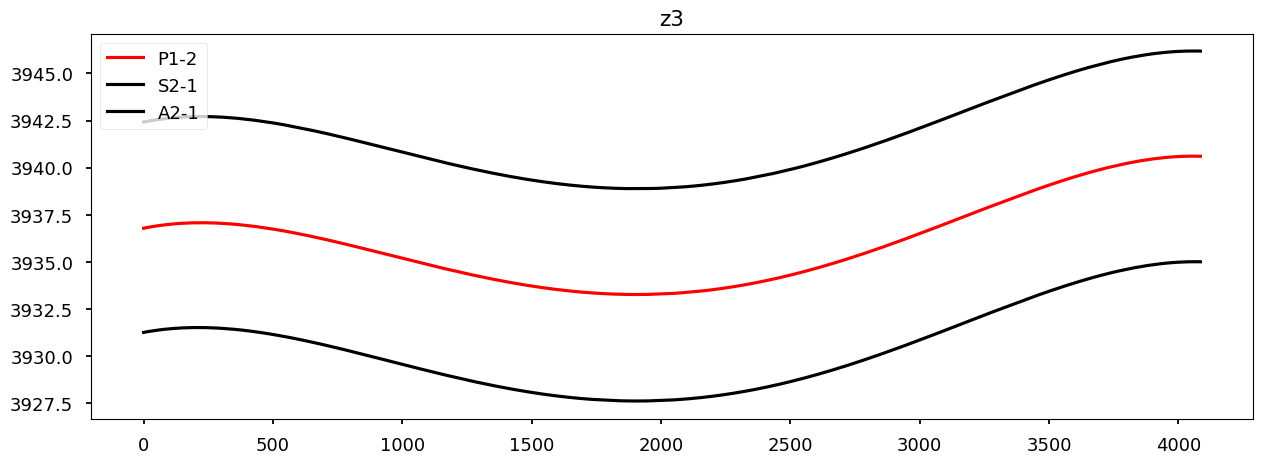

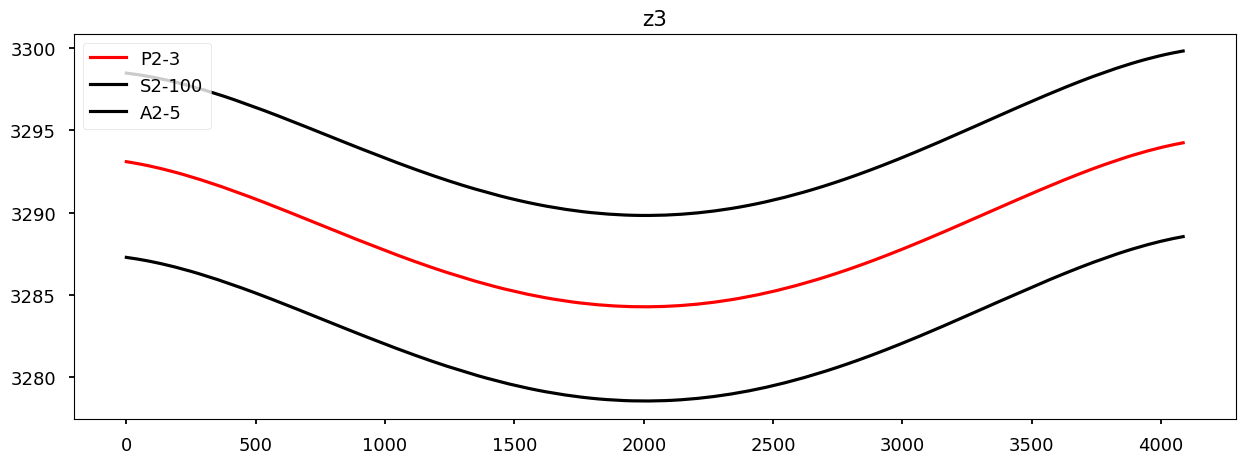

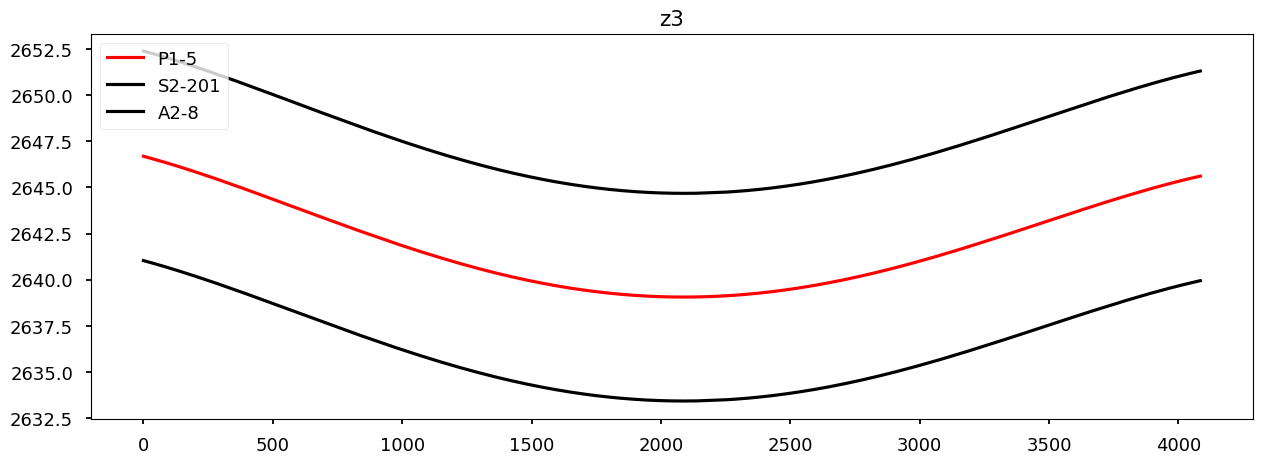

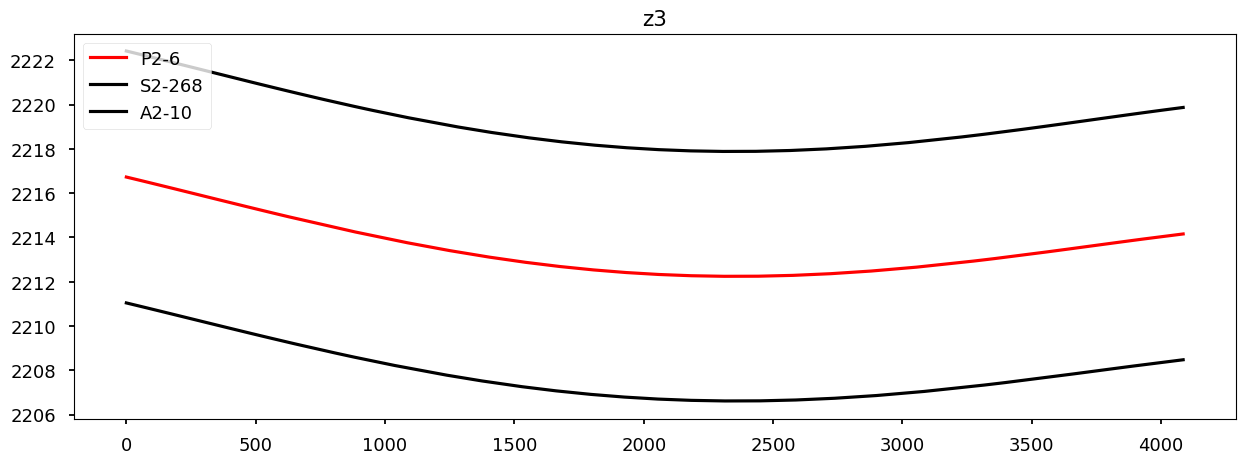

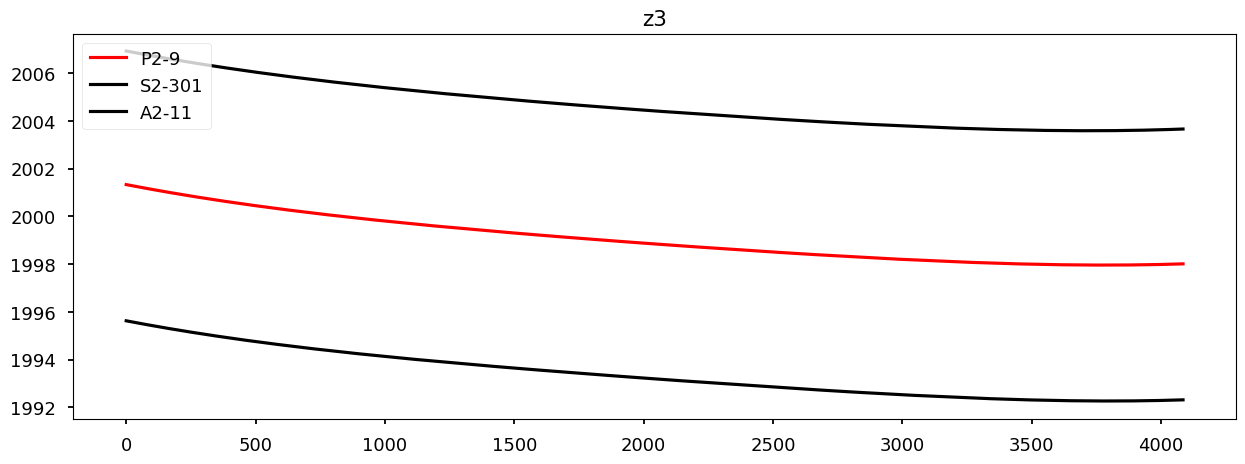

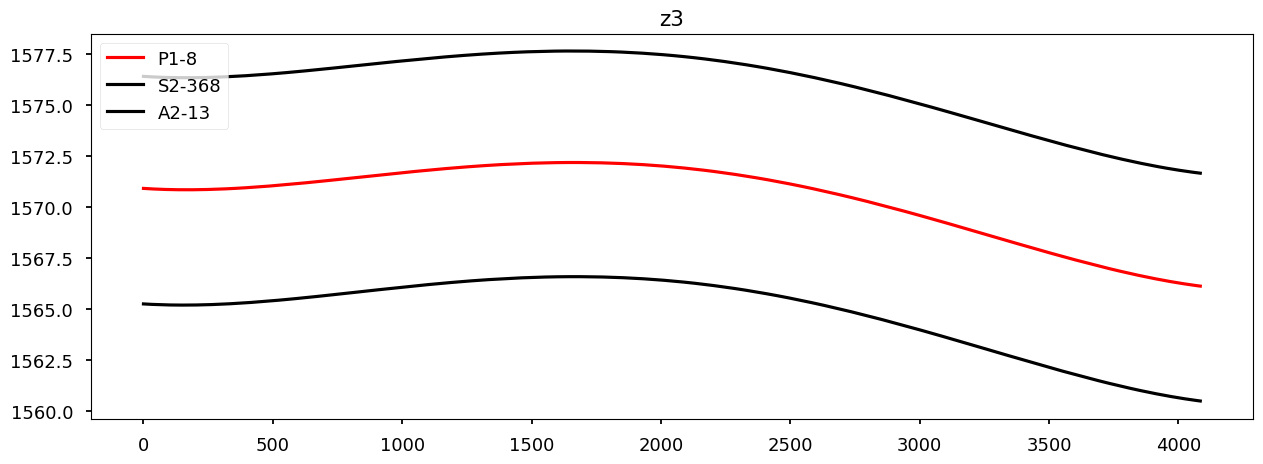

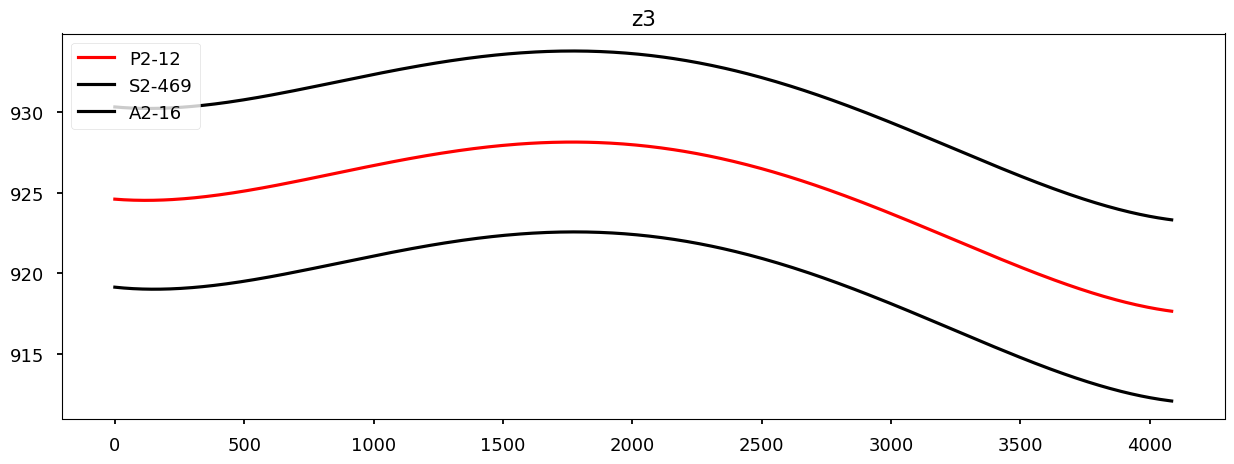

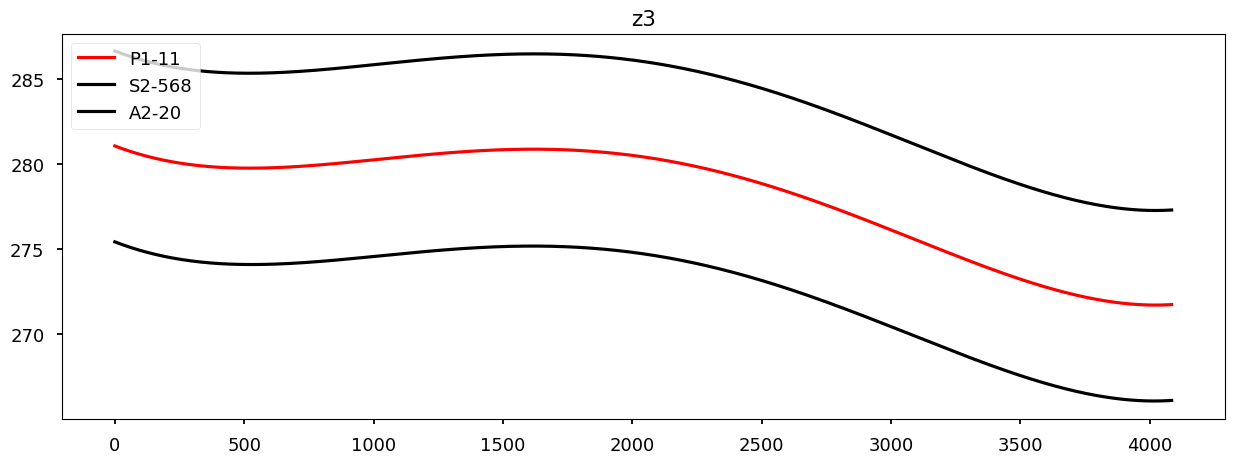

In [22]:
camera = "z3"
trace = copy(mcents[camera])

fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
select = fibermap["telescope"] == "Spec"
con_lamp = MASTER_CON_LAMPS[camera[0]]

ifibers = np.where(select)[0]
for idx in ifibers:
    plt.figure(figsize=(15, 5))
    plt.plot(trace._data[idx], color="r", label=fibermap[idx]["orig_ifulabel"])
    plt.plot(trace._data[idx+1], color="k", label=fibermap[idx+1]["orig_ifulabel"])
    plt.plot(trace._data[idx-1], color="k", label=fibermap[idx-1]["orig_ifulabel"])
    plt.title(f"{camera}")
    plt.legend(loc=2)

In [8]:
# for camera in flat_analogs.groups:
    
#     con_lamp = MASTER_CON_LAMPS[camera[0]]
#     arc_lamp = MASTER_ARC_LAMPS[camera[0]]

#     mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
#     mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
#     mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
#     mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
#     # define master fiberflat path
#     mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{con_lamp}", camera=camera)
#     wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)

#     # if os.path.isfile(wflat_path):
#     #     print(f"skipping {wflat_path}, file already exist")
#     #     continue

#     # extract fiberflats
#     imageMethod.extract_spectra(in_image=mflat_path, out_rss=wflat_path, in_trace=mtrace_path, in_fwhm=mwidth_path, method="optimal", parallel=4)

#     # apply correction factor for the std fibers
#     fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
#     select = fibermap["telescope"] == "Spec"
#     flat = rssMethod.loadRSS(wflat_path)
#     flat._data[select] = flat._data[select] * 24
#     flat._error[select] = flat._error[select] * 24
#     flat.writeFitsData(wflat_path)

#     rssMethod.create_pixel_table(in_rss=wflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

In [9]:
# for camera in flat_analogs.groups.keys():
#     fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
#     select = fibermap["telescope"] == "Spec"
#     con_lamp = MASTER_CON_LAMPS[camera[0]]

#     mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
#     trace = TraceMask()
#     trace.loadFitsData(mtrace_path)
#     trace._data[select]

#     plt.figure(figsize=(10, 5))
#     idx = np.where(select)[0]
#     plt.plot(trace._data[idx][0], color="r")
#     plt.plot(trace._data[idx+1][0], color="k")
#     plt.plot(trace._data[idx-1][0], color="k")
#     plt.title(f"{camera}")

#     wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)
#     flat = rssMethod.loadRSS(wflat_path)
#     flat._data[flat._mask] = np.nan

#     plt.figure(figsize=(10, 5))
#     plt.plot(flat._wave[select].T, flat._data[select].T, label="std")
#     plt.title(f"{camera}")

In [10]:
# idx = 1

# flat = rssMethod.loadRSS(mfiberflat_paths[idx])
# print(mfiberflat_paths[idx])

# fibermap = SLITMAP[SLITMAP["spectrographid"] == 1]
# select = fibermap["telescope"] == "Spec"
# print(fibermap[select])
# plt.plot(flat._wave[~select][:12].T, flat._data[~select][:12].T)
# plt.plot(flat._wave[select].T, flat._data[select].T, "-k")